In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folder_path = 'WC/pressure_2022' # specify the folder path containing your CSV files
files = [file for file in os.listdir(folder_path) if file.endswith('.csv')] # get a list of all CSV files in the folder

# loop through each file and load it into a DataFrame
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, usecols=[0, 1, 2], parse_dates=[0]) # the parser will automatically convert the first column to datetime!
    df.set_index('Date_Time', inplace=True) # set the datetime column as the index
    variable_name = f'{file.split(".")[0].replace("-", "_").replace(" ", "_").replace(".", "_")}'
    exec(f"{variable_name} = df") 

I need to interpolate the time values, since the start and end time for the barometer is different.

In [2]:
# get the barometric DataFrame
barom_df = eval('BAROM_22')
# resample the DataFrame to a 5-minute frequency
barom_df_resampled = barom_df.resample('5T')
# interpolate the missing values
barom_df_interpolated = barom_df_resampled.interpolate(method='time')
#print(barom_df_interpolated.index)
BAROM_22 = barom_df_interpolated

# I need to do the same with P1B
P1B_df = eval('P1B_22')
P1B_df.index = pd.to_datetime(P1B_df.index)
# resample the DataFrame to a 1-minute frequency
P1B_22_RESAMPLED = P1B_df.resample('1T')
# interpolate the missing values
P1B_22_interpolated = P1B_22_RESAMPLED.interpolate(method='time')
print(P1B_22_interpolated.index)
P1B_22 = P1B_22_interpolated

DatetimeIndex(['2022-02-28 00:00:00', '2022-02-28 00:01:00',
               '2022-02-28 00:02:00', '2022-02-28 00:03:00',
               '2022-02-28 00:04:00', '2022-02-28 00:05:00',
               '2022-02-28 00:06:00', '2022-02-28 00:07:00',
               '2022-02-28 00:08:00', '2022-02-28 00:09:00',
               ...
               '2022-08-01 12:51:00', '2022-08-01 12:52:00',
               '2022-08-01 12:53:00', '2022-08-01 12:54:00',
               '2022-08-01 12:55:00', '2022-08-01 12:56:00',
               '2022-08-01 12:57:00', '2022-08-01 12:58:00',
               '2022-08-01 12:59:00', '2022-08-01 13:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=222541, freq='T')


Add the barometric pressure as a new column to each DataFrame:

In [3]:
# get the barometric DataFrame
barom_df = eval('BAROM_22')
# rename the pressure column name to barom
barom_df.rename(columns={'Pressure': 'Barom'}, inplace=True)

# iterate over all file names in the 'files' list
for file in files:
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    
    if df_name != 'BAROM_22': # skip the 'BAROM_SM23' DataFrame
        # get the DataFrame by its variable name
        df = eval(df_name)
        # merge the column from 'BAROM_SM23' DataFrame on the index
        df = df.join(barom_df['Barom'])
        # drop the rows with missing values
        df.dropna(inplace=True)
        # assign the result back to the DataFrame variable
        exec(f"{df_name} = df")

First we will calculate the WC above the divers, which can be estimated as: 

$WC = 9806.65 * \frac{(P_{diver} - P_{baro})}{\rho g}$

In [4]:
g = 9.81 #(m/s^2)
rho = 1000 #(kg/m^3)

for i, file in enumerate(files):
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    if df_name != 'BAROM_22' and df_name != 'piezometer_WSE_2023_corrected': # skip the barom and corrected data
        # get the DataFrame by its variable name
        print(df_name)
        df = eval(df_name)

        #get the parameters
        pressure = df['Pressure']   # pressure reading in cmH2O
        temp = df['Temperature']    # water temperature in degrees Celsius
        barom = df['Barom']  # atmospheric pressure in cmH2O

        # calculate the water column above the diver in cmH2O
        WC = ((pressure - barom) / (rho * 9.81)) * 9806.65

        # add the water depth as a new column to the DataFrame
        df['WC'] = WC

        # Save the DataFrame to a CSV file
        #df.to_csv(f"{df_name}_WC.csv")

        # Assign the result back to the DataFrame variable
        exec(f"{df_name} = df")

P1A_22
P1B_22
P1C_22
P2A_22
P2B_22
P2C_22
P3A_22
P3B_22
P3C_22
P4A_22
P4B_22
P4C_22
P5A_22
P5B_22
P5C_22
P6A_22
P6B_22
P6C_22


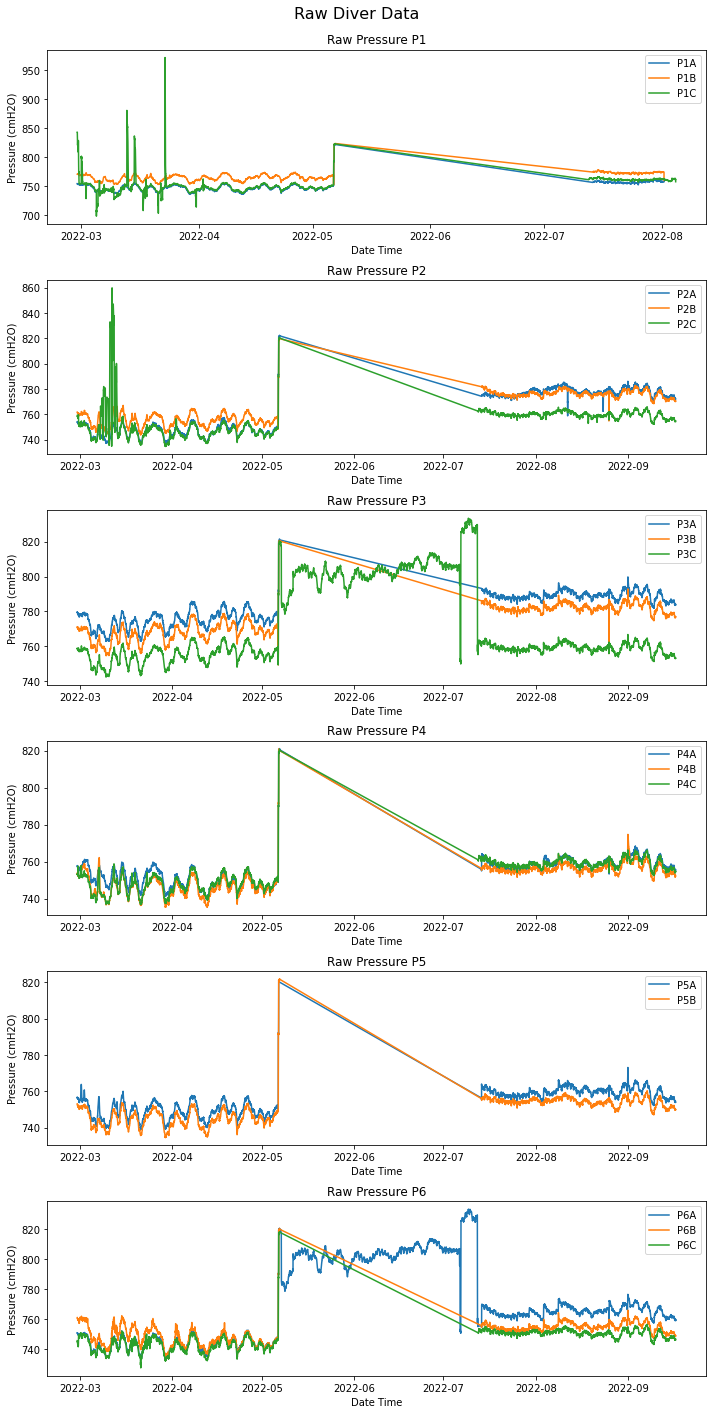

In [5]:
import matplotlib.pyplot as plt

# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_22'
        
        # Skip the iteration if the DataFrame name is 'P5C_23'
        if df_name == 'P5C_22':
            continue

        # Get the DataFrame by its variable name
        df = eval(df_name)
        # Plot the 'WC' series
        ax.plot(df['Pressure'], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'Raw Pressure P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('Pressure (cmH2O)')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Raw Diver Data', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plots
plt.savefig('Raw_Diver_Data_2022.png', dpi=300)
plt.show()

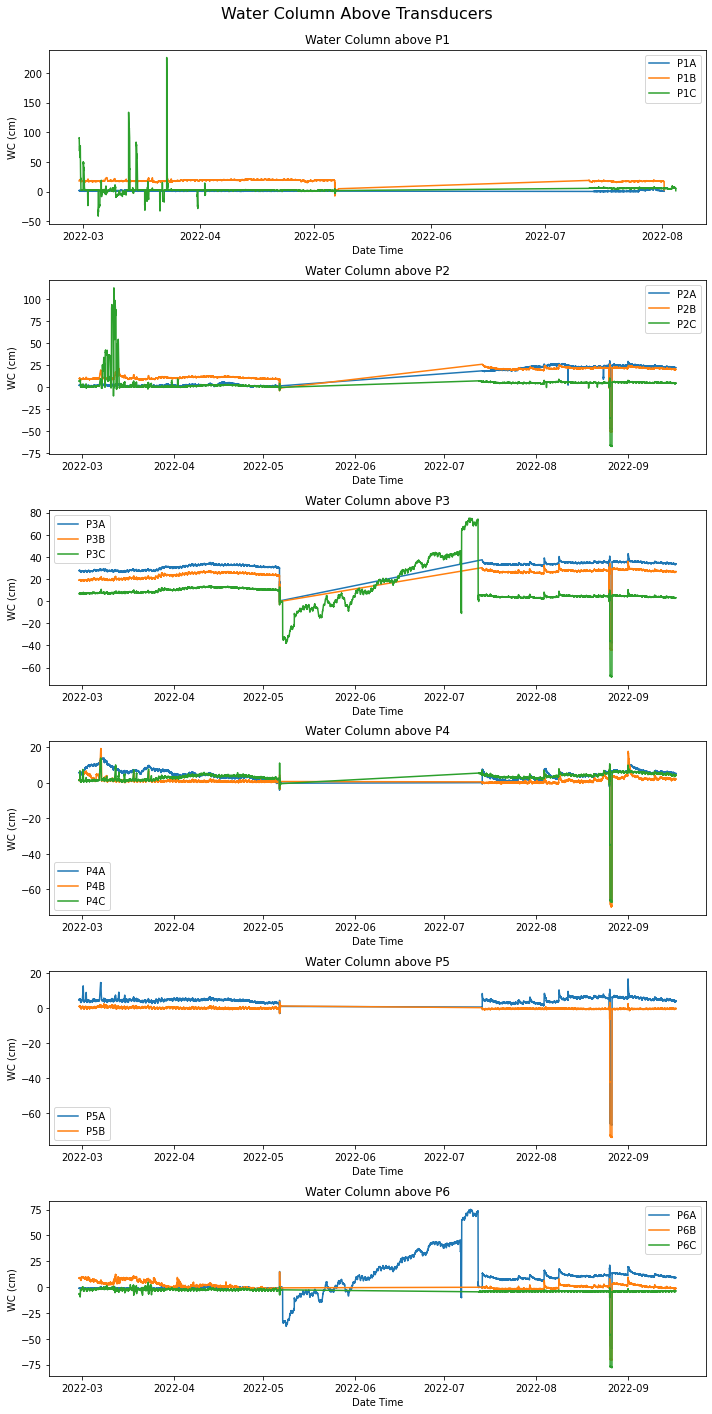

In [6]:
# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_22'
        
        # Skip the iteration if the DataFrame name is 'P5C_23'
        if df_name == 'P5C_22':
            continue

        # Get the DataFrame by its variable name
        df = eval(df_name)
        # Plot the 'WC' series
        ax.plot(df['WC'], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'Water Column above P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('WC (cm)')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Water Column Above Transducers', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plots
plt.savefig('WC_2022.png', dpi=300)
plt.show()

Now we want to calculate the WSE, by knowing the top of the PVC pipes as well as the length of the strings that are attached to the pressure transducers

In [12]:
piezo_depths_23 = [0.746, 0.514, 0.398, 0.69, 0.575, 0.428, 0.616, 0.562, 0.293, 
                    0.656, 0.56, 0.384, 0.724, 0.586, 0.477, 0.705, 0.574, 0.40]

piezo_depths_21 = [0.696, 0.525, 0.376, 0.526, 0.49, 0.393, 0.604, 0.557, 0.38, 
                    0.67, 0.514, 0.397, 0.711, 0.532, 0.383, 0.643, 0.551, 0.393]

piezo_elevs_23 = [2722.167, 2722.157, 2722.207, 2723.406, 2723.422, 2723.509, 2724.488, 2724.498, 2724.488,
                2733.4367, 2733.42, 2733.42, 2736.708, 2736.7167, 2736.7, 2737.7645, 2737.737, 2737.72] # the order is P1 thru 6 (A,B,C)

piezo_indices = {'P1A_22': 0, 'P1B_22': 1, 'P1C_22': 2, 'P2A_22': 3, 'P2B_22': 4, 'P2C_22': 5, 
                'P3A_22': 6, 'P3B_22': 7, 'P3C_22': 8, 'P4A_22': 9, 'P4B_22': 10, 'P4C_22': 11, 
                'P5A_22': 12, 'P5B_22': 13, 'P5C_22': 14, 'P6A_22': 15, 'P6B_22': 16, 'P6C_22': 17}

In [17]:
# Iterate over the piezometer numbers and the axes
for i in range(1, 7):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_22'
        df = eval(df_name)

        # Define a function to calculate WSE based on the date
        def calculate_WSE(row):
            date_time = row.name
            elevation = piezo_elevs_23[piezo_indices[df_name]]
            if date_time < pd.Timestamp('2022-06-20 00:00:00'):
                depth = piezo_depths_21[piezo_indices[df_name]]
            elif date_time > pd.Timestamp('2022-07-04 00:00:00'):
                depth = piezo_depths_23[piezo_indices[df_name]]
            else:
                depth = elevation + (row['WC']/100)  # this will make the WSE equal to 0
            return elevation - depth + (row['WC']/100) # remember that WC is in centimeters (needed to convert)

        # Apply the function to each row
        df['WSE'] = df.apply(calculate_WSE, axis=1)
        df = df.loc[df['WSE'] != 0]

        # Save the DataFrame to a CSV file
        df.to_csv(f"{df_name}_WSE.csv")

Now we will plot the water surface elevations! 

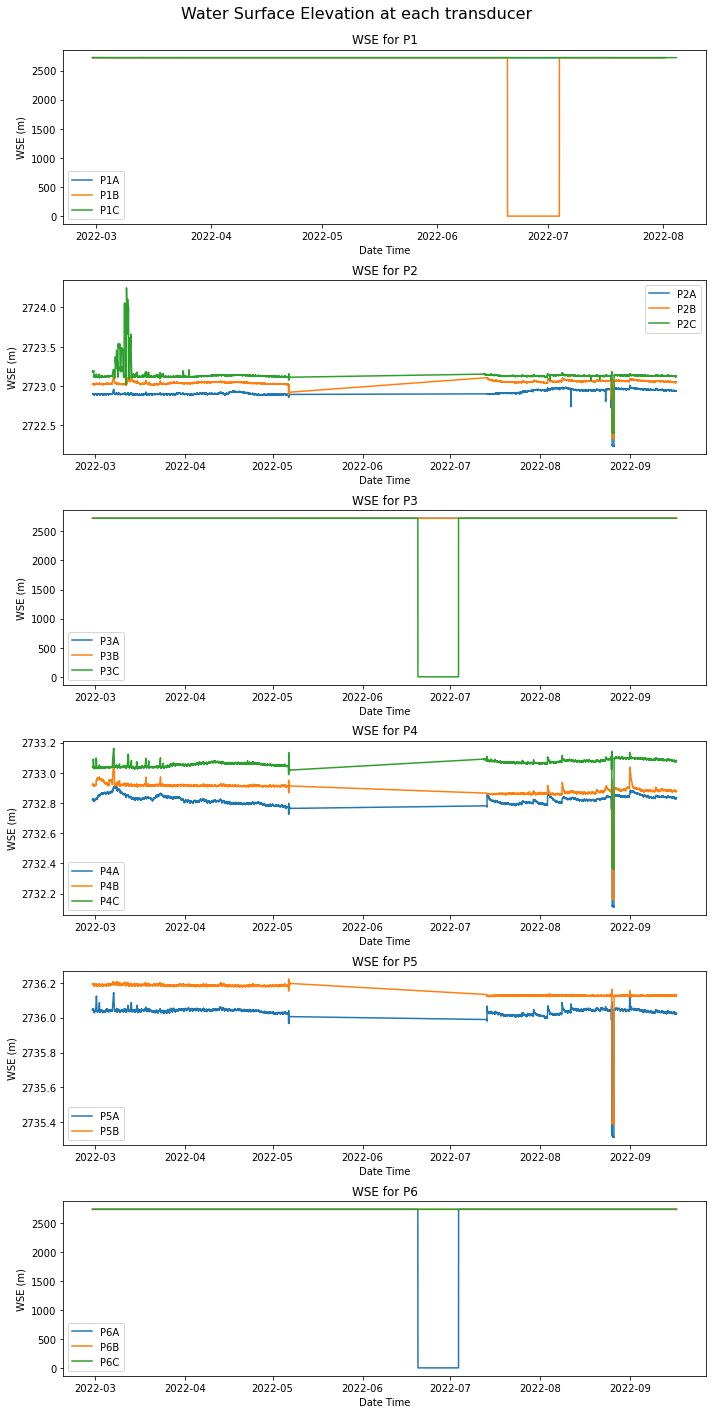

In [18]:
# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the DataFrame name
        df_name = f'P{i}{pipe}_22'
        
        # Skip the iteration if the DataFrame name is 'P5C_23'
        if df_name == 'P5C_22':
            continue

        # Get the DataFrame by its variable name
        df = eval(df_name)
        # Plot the 'WC' series
        ax.plot(df['WSE'], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'WSE for P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('WSE (m)')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Water Surface Elevation at each transducer', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plots
plt.savefig('WSE_2022.png', dpi=300)
plt.show()

All this data will be manually corrected in excel to later on export and calculate the vertical hydraulic gradient for each :)

# POST CORRECTION

I finished correcting that data, and I now want to plot the corrected WSE and calculate the vertical hydraulic gradient (VHG). 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

corrected_WSE = pd.read_csv('WC/piezometer_WSE_2023_corrected.csv')

# convert the 'date_time_P1B' column to datetime format
corrected_WSE['Date_Time_P1B'] = pd.to_datetime(corrected_WSE['Date_Time_P1B'])
corrected_WSE['Date_Time'] = pd.to_datetime(corrected_WSE['Date_Time'])

C:\Users\nicol\AppData\Local\Temp\ipykernel_30424\959480910.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  corrected_WSE = pd.read_csv('WC/piezometer_WSE_2023_corrected.csv')


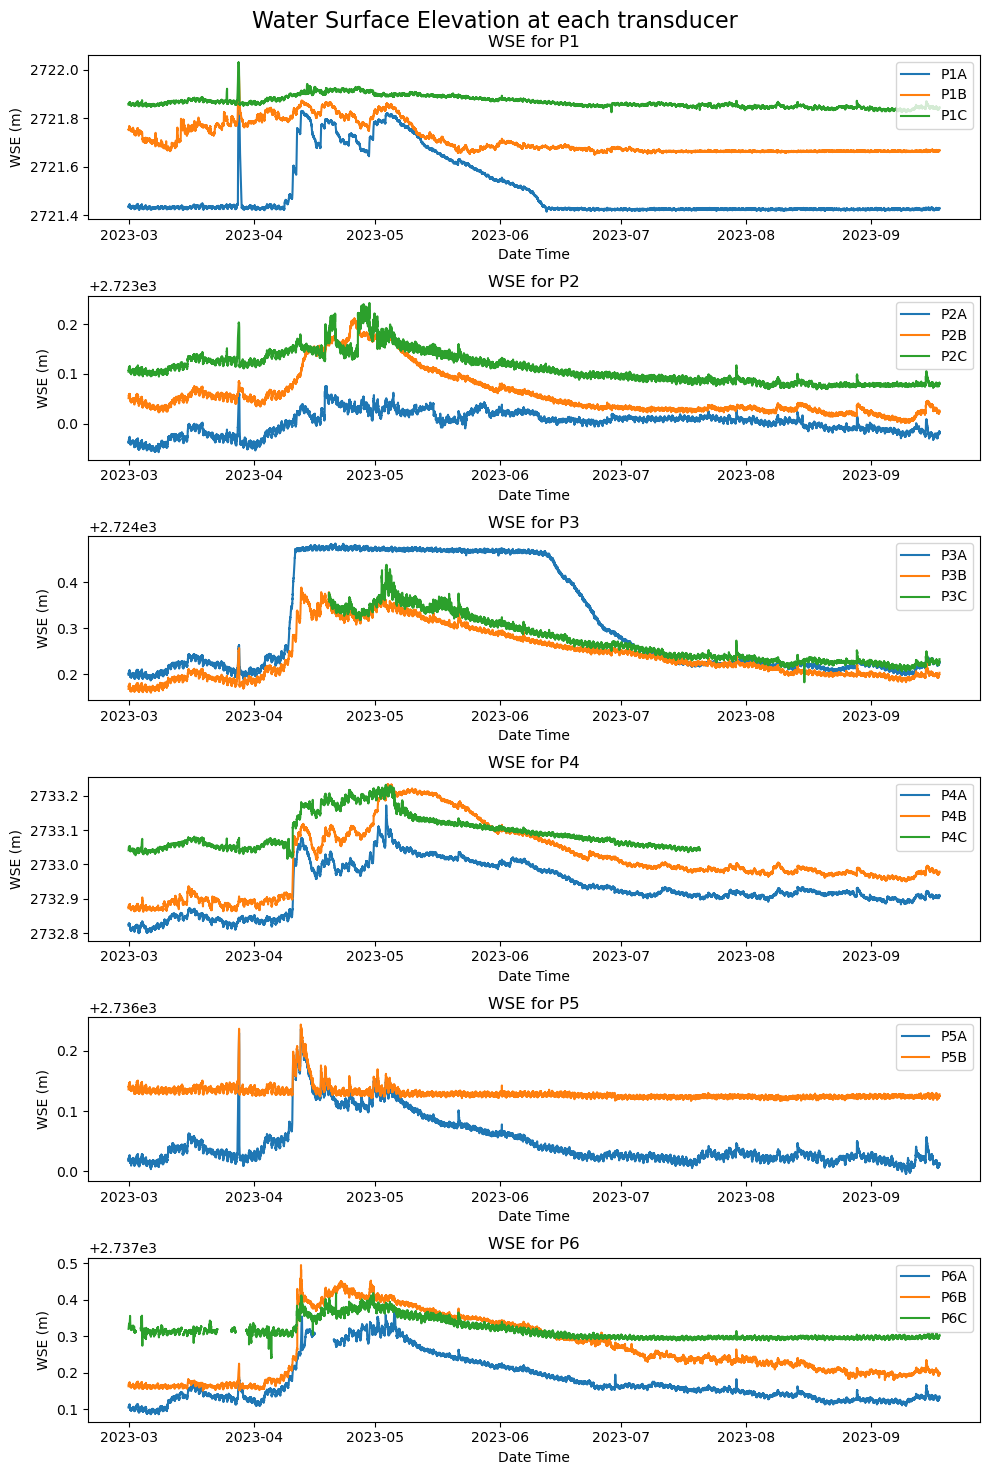

In [ ]:
# Create a new figure with 6 subplots
fig, axs = plt.subplots(6, figsize=(10, 15))
fig.patch.set_facecolor('white')

# List of pipe letters
pipes = ['A', 'B', 'C']

# Iterate over the piezometer numbers and the axes
for i, ax in enumerate(axs, start=1):
    # Iterate over the pipe letters
    for pipe in pipes:
        # Construct the column name
        col_name = f'P{i}{pipe}'
        
        # Skip the iteration if the column name is 'P5C'
        if col_name == 'P5C':
            continue

        # Check if the current pipe is 'P1B'
        if col_name == 'P1B':
            # Use the 'date_time_P1B' column for the x-axis
            ax.plot(corrected_WSE['Date_Time_P1B'], corrected_WSE[col_name], label=f'P{i}{pipe}')
        else:
            # Plot the 'WSE' series
            ax.plot(corrected_WSE['Date_Time'], corrected_WSE[col_name], label=f'P{i}{pipe}')
    # Set the title and labels
    ax.set_title(f'WSE for P{i}')
    ax.set_xlabel('Date Time')
    ax.set_ylabel('WSE (m)')
    # Add a legend
    ax.legend()

# Adjust the layout
plt.tight_layout()
fig.suptitle('Water Surface Elevation at each transducer', fontsize=16)
plt.subplots_adjust(top=0.95)

# Save and display the plots
plt.savefig('WSE_corrected_2023.png', dpi=300)
plt.show()

In [ ]:

# Create a new DataFrame with 'Date_Time_P1B' and 'P1B'
df_P1B = corrected_WSE[['Date_Time_P1B', 'P1B']].copy()
df_P1B.rename(columns={'Date_Time_P1B': 'Date_Time'}, inplace=True)

# Drop the 'Date_Time_P1B' and 'P1B' columns
corrected_WSE = corrected_WSE.drop(['Date_Time_P1B', 'P1B'], axis=1)

# Merge corrected_WSE with df_P1B on 'Date_Time'
corrected_WSE = pd.merge(corrected_WSE, df_P1B, on='Date_Time', how='left')

Calculate VHG for the different piezometers

In [ ]:
# Create a new DataFrame for the differences
B_A = pd.DataFrame()
C_B = pd.DataFrame()
C_A = pd.DataFrame()

# Set the first column to be 'Date_Time'
B_A['Date_Time'] = corrected_WSE['Date_Time']
C_B['Date_Time'] = corrected_WSE['Date_Time']
C_A['Date_Time'] = corrected_WSE['Date_Time']

# List of piezometer numbers
piezometers = [1, 2, 3, 4, 5, 6]

# Calculate the differences
for i in piezometers:
    B_A[f'P{i}'] = corrected_WSE[f'P{i}A'] - corrected_WSE[f'P{i}B']
    C_B[f'P{i}'] = corrected_WSE[f'P{i}B'] - corrected_WSE[f'P{i}C']
    C_A[f'P{i}'] = corrected_WSE[f'P{i}A'] - corrected_WSE[f'P{i}C']

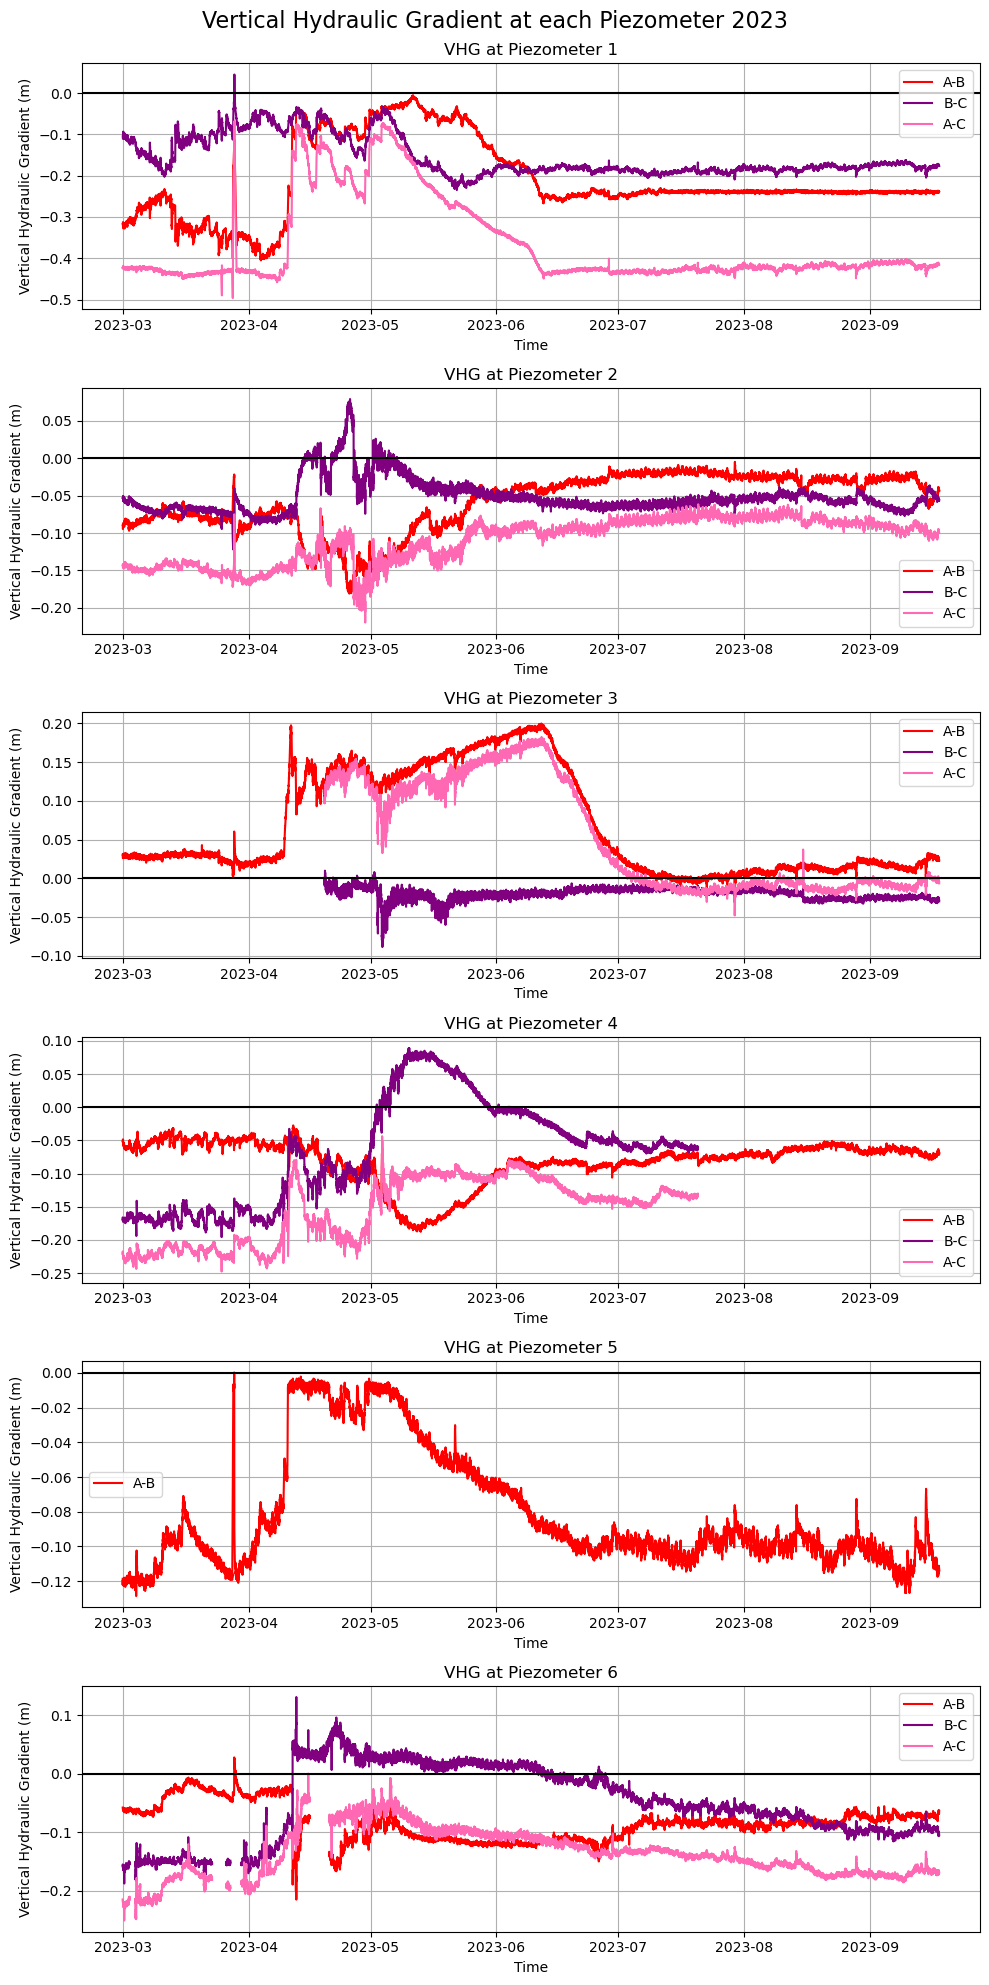

In [ ]:
# Create a figure with 6 subplots, one for each piezometer
fig, axs = plt.subplots(6, figsize=(10, 20))
fig.patch.set_facecolor('white')

for i, ax in enumerate(axs):
    # Plot the 'B_A', 'C_B', and 'C_A' values for each piezometer
    ax.plot(B_A['Date_Time'], B_A[f'P{piezometers[i]}'], label='A-B', color='r')

    # Only plot 'B-C' and 'A-C' if the piezometer number is not 5
    if piezometers[i] != 5:
        ax.plot(C_B['Date_Time'], C_B[f'P{piezometers[i]}'], label='B-C', color='purple')
        ax.plot(C_A['Date_Time'], C_A[f'P{piezometers[i]}'], label='A-C', color='hotpink')

    # Set the title and labels
    ax.set_title(f'VHG at Piezometer {piezometers[i]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Vertical Hydraulic Gradient (m)')

    # Add a legend
    ax.legend()
    # Add grid lines
    ax.grid(True)
    # Add a darker horizontal line at Y=0
    ax.axhline(0, color='black')

# Adjust the layout
fig.suptitle('Vertical Hydraulic Gradient at each Piezometer 2023', fontsize=16, y=0.99)
plt.subplots_adjust(top=0.9)
plt.tight_layout()

# Show the plot
plt.savefig('VHG_2023.png', dpi=300)
plt.show()

In [ ]:
cd =C:\Users\nicol\Documents\GitHub\La_Jara\Diver_Data\barometric_compensation.ipynb

C:\Users\nicol


This is how I did it before: 

In [ ]:
# use 1 from SM21 to SP22
transducer_depths_1 = [1.016, 0.89, 1.107, 1.122, 1.061, 1.071, 1.088, 1.138, 0.921, 
                        0.696, 0.525, 0.376, 0.526, 0.49, 0.393, 0.604, 0.557, 0.38, 0.67, 0.514, 
                        0.397, 0.711, 0.532, 0.383, 0.643, 0.551, 0.393]
# use 2 from SM22 to SM23
transducer_depths_2 = [0.97, 1.04, 1.04, 1.07, 1.044, 1.054, 1.045, 1.005, 0.988, 0.746, 
                        0.514, 0.398, 0.69, 0.575, 0.428, 0.616, 0.562, 0.293, 0.656, 0.56, 
                        0.384, 0.724, 0.586, 0.477, 0.705, 0.574, 0.40]

densities = pd.read_csv('water_densities.csv', usecols=[0, 1]) 
# this table contains the water density at different temperatures at 1 atm pressure (our barom is a little bit less than that)
# (source: https://www.engineeringtoolbox.com/water-density-specific-weight-d_595.html)

# Extract the temperature and density columns from the densities DataFrame
temp_values = densities['Temperature'].values
density_values = densities['Density (g/cm3)'].values

for i, file in enumerate(files):
    # get the DataFrame name by removing the '.csv' extension from the file name
    df_name = file[:-4]
    if df_name != 'BAROM_SM23': # skip the 'BAROM_SM23' DataFrame
        # get the DataFrame by its variable name
        print(df_name)
        df = eval(df_name)

        #get the parameters
        pressure = df['Pressure']   # Pressure reading in cmH2O
        temp = df['Temperature']    # Water temperature in degrees Celsius
        barom = df['Barom']  # Atmospheric pressure in cmH2O
        d_transducer = transducer_depths_2[i-1] # Depth of the pressure transducer in m (from the list above)

        print('The transducer depth for', df_name, 'is:' , d_transducer, 'm')

        # convert the pressure from cmH2O to Pascals
        barom_pa = barom * 98.0665
        pressure_pa = pressure * 98.0665

        # interpolate the water density at the measured temperature (originally in g/cm3)
        rho = np.interp(temp, temp_values, density_values) * 1000 # convert the density to kg/m3

        # calculate the water depth
        h = ((pressure_pa - barom_pa) / (rho * 9.81))
        # This is how I calculated it for the stilling wells
        # h = ((pressure_pa - barom_pa) / (rho * 9.81)) + (0.5 - d_transducer)

        # add the water depth as a new column to the DataFrame
        df['WaterDepth'] = h

        # Save the DataFrame to a CSV file
        df.to_csv(f"{df_name}_depth.csv")

        # Assign the result back to the DataFrame variable
        exec(f"{df_name} = df")



GW1_SM23
The transducer depth for GW1_SM23 is: 0.97 m
GW2_SM23
The transducer depth for GW2_SM23 is: 1.04 m
GW3_SM23
The transducer depth for GW3_SM23 is: 1.04 m
GW4_SM23
The transducer depth for GW4_SM23 is: 1.07 m
GW5_SM23
The transducer depth for GW5_SM23 is: 1.044 m
GW6_SM23
The transducer depth for GW6_SM23 is: 1.054 m
GW7_SM23
The transducer depth for GW7_SM23 is: 1.045 m
GW8_SM23
The transducer depth for GW8_SM23 is: 1.005 m
GW9_SM23
The transducer depth for GW9_SM23 is: 0.988 m
P1A_SM23
The transducer depth for P1A_SM23 is: 0.746 m
P1B_SM23
The transducer depth for P1B_SM23 is: 0.514 m
P1C_SM23
The transducer depth for P1C_SM23 is: 0.398 m
P2A_SM23
The transducer depth for P2A_SM23 is: 0.69 m
P2B_SM23
The transducer depth for P2B_SM23 is: 0.575 m
P2C_SM23
The transducer depth for P2C_SM23 is: 0.428 m
P3A_SM23
The transducer depth for P3A_SM23 is: 0.616 m
P3B_SM23
The transducer depth for P3B_SM23 is: 0.562 m
P3C_SM23
The transducer depth for P3C_SM23 is: 0.293 m
P4A_SM23
The tr